## Principled Probabilistic Imaging using Diffusion Models as Plug-and-Play Priors
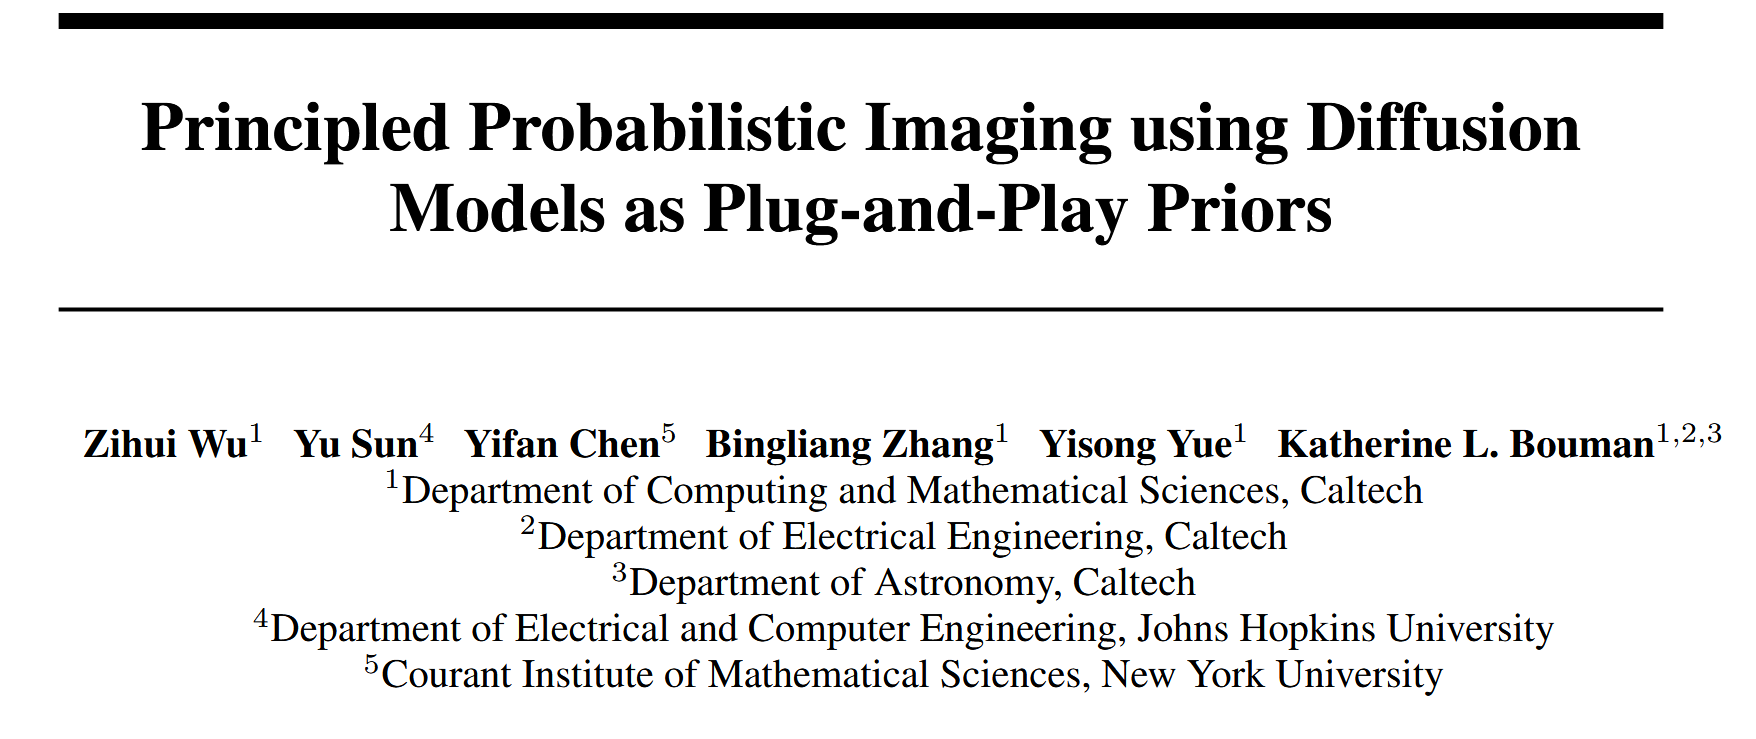
Github Repo: https://github.com/zihuiwu/PnP-DM-public, 
Corresponding code: ../../../../code/PnP/PnP-DM-public-master/posterior_sample.py

## 1. Highlights

While traditional guided diffusion heuristically guides generation toward observations, **PnP-DM is a principled method that rigorously samples from the true posterior \( p(x|y) \)**, making it a fully Bayesian alternative with no approximations to the likelihood.
The **prior step** handles $p(x)$, which is entirely determined by the diffusion model.
## 2. Background

Inverse problems are central to computational imaging.
In recent years, **diffusion models (DMs)** have emerged as powerful generative models that can learn rich and high-dimensional image distributions from data [Ho et al., 2020; Song et al., 2021]. These models enable denoising-based sampling by reversing a noise-injection (diffusion) process. This has sparked interest in using DMs as **priors** for inverse problems.

However, existing approaches suffer from a key limitation: they either make **simplifying assumptions** that break the Bayesian formulation or resort to **heuristic guidance** that lacks theoretical grounding. For example, some methods approximate the intractable posterior score $\nabla \log p_t(x_t|y)$ using:

$$
\nabla \log p_t(x_t|y) \approx \nabla \log p_t(y|x_t) + \nabla \log p_t(x_t)
$$

But this is only exact under a Gaussian prior, which is too simplistic for real images. Other methods bypass this issue entirely by treating $y$ as a conditioning signal, leading to empirically strong but theoretically ungrounded solutions.

**This paper addresses these issues by proposing a principled and theoretically sound method for posterior sampling with DMs as priors.**

Specifically, the authors introduce a **Plug-and-Play Diffusion Model (PnP-DM)** framework built on the **Split Gibbs Sampler (SGS)**.This allows the method to handle both linear and **nonlinear**, even **severely ill-posed** inverse problems (e.g., black hole imaging), while offering accurate **uncertainty quantification**.

## 3. The Core Idea

The core of this paper is a **Bayesian sampling framework** that separates the influence of data (likelihood) and prior (image distribution) in a principled way. The proposed method, called **Plug-and-Play Diffusion Models (PnP-DM)**, is based on the **Split Gibbs Sampler (SGS)**.

### 3.1 From Posterior Sampling to Gibbs Sampling

The target is to sample from the posterior distribution:

$$
p(x|y) \propto p(y|x)p(x) = \exp(-f(x; y) - g(x))
$$

where:
- $f(x; y) := -\log p(y|x)$ is the **likelihood potential**
- $g(x) := -\log p(x)$ is the **prior potential**

Directly sampling from this posterior is hard. So the authors introduce an auxiliary variable $z$ and define a joint distribution:

$$
\pi(x, z) \propto \exp\left(-f(z; y) - g(x) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

This leads to a **Gibbs sampler** that alternates between:
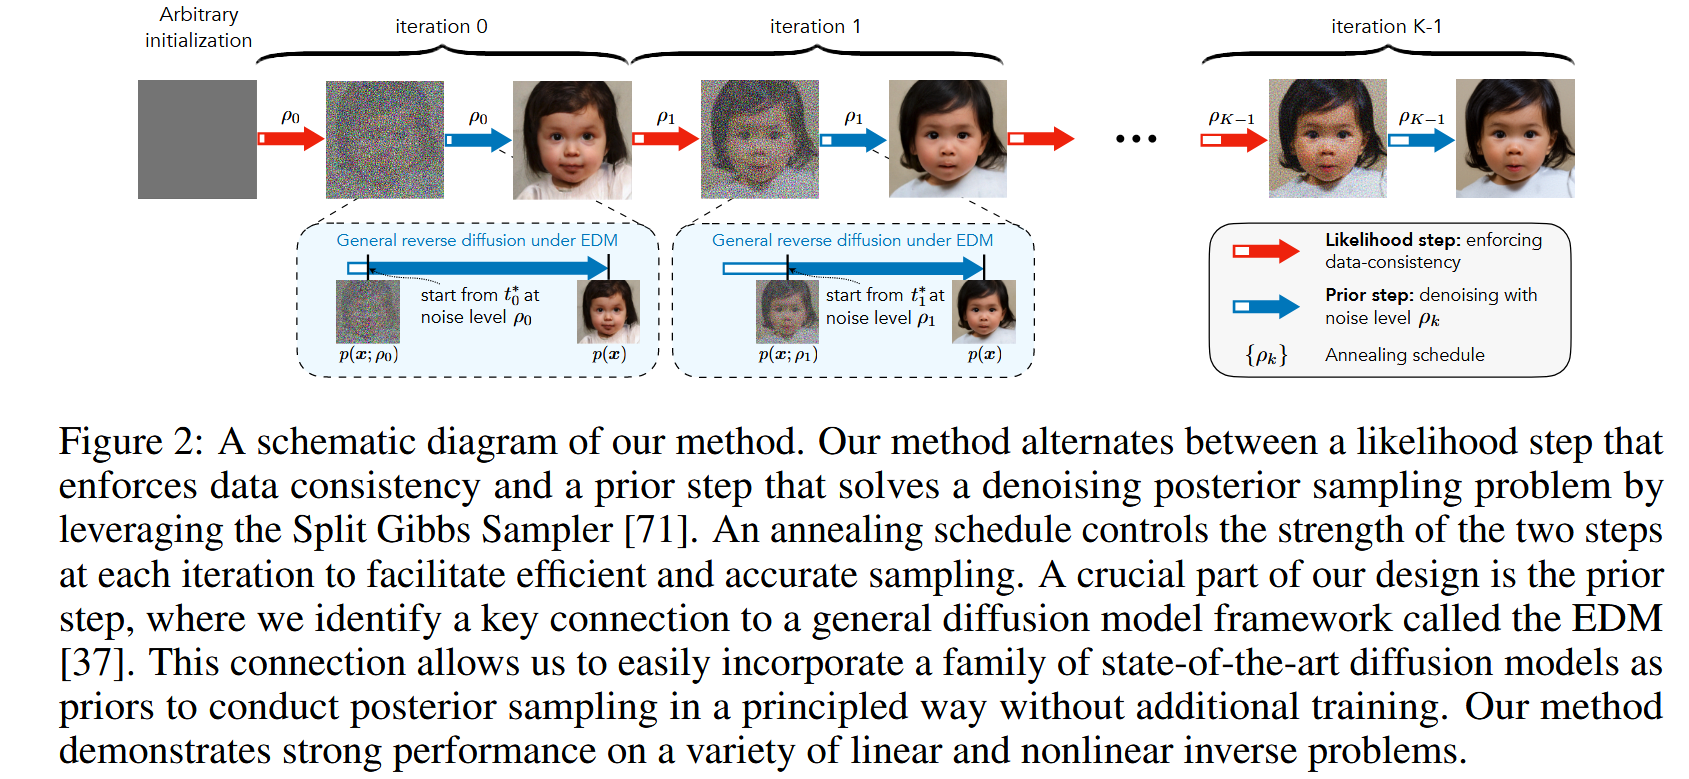
- **Likelihood step**: sample $z$ from $\pi(z|x)$ (red arrow in the Figure)
- **Prior step**: sample $x$ from $\pi(x|z)$ (blue arrow in the Figure)

As $\rho \to 0$, the marginal of $\pi(x, z)$ over $x$ converges to $p(x|y)$.

#### 3.1.1 Likelihood Step

In the likelihood step, we need to sample $z$ from the conditional distribution $\pi(z|x)$, which incorporates the observation $y$. This step enforces **data consistency**—i.e., it makes sure that the sample is plausible under the observed measurements.

#### 3.1.1.1 Case 1: Linear Forward Model + Gaussian Noise

Suppose the forward model is **linear**, i.e., $A(x) = Ax$, and the noise is Gaussian: $n \sim \mathcal{N}(0, \Sigma)$. Then the observation model is:

$$
y = Ax + n
$$

The likelihood is therefore a Gaussian:

$$
p(y|x) = \mathcal{N}(Ax, \Sigma)
$$

Taking the negative log, the likelihood potential becomes:

$$
f(x; y) = -\log p(y|x) = \frac{1}{2} \| y - Ax \|^2_\Sigma
$$

where $\|v\|^2_\Sigma := v^\top \Sigma^{-1} v$ is the Mahalanobis norm.

Now recall the joint distribution:

$$
\pi(z|x) \propto \exp\left( -f(z; y) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

This is the product of two Gaussians:
- One centered at $z \approx A^{-1} y$
- One centered at $z \approx x$

Combining two Gaussians gives another Gaussian. Therefore, $\pi(z|x)$ is Gaussian:

$$
\pi(z|x) = \mathcal{N}(m(x), \Lambda^{-1})
$$

with:

$$
\Lambda = A^\top \Sigma^{-1} A + \frac{1}{\rho^2} I
$$

$$
m(x) = \Lambda^{-1} \left( A^\top \Sigma^{-1} y + \frac{1}{\rho^2} x \right)
$$

So, in the linear + Gaussian case, we can directly draw $z$ from this distribution using standard Gaussian sampling.



#### 3.1.1.2 Case 2: Nonlinear Forward Model

If the forward model $A(\cdot)$ is **nonlinear**, or the noise is **non-Gaussian**, then the distribution $\pi(z|x)$ is no longer Gaussian and no closed-form exists.

But we can still compute the **unnormalized log-probability**:

$$
\log \pi(z|x) = -f(z; y) - \frac{1}{2\rho^2} \|x - z\|^2 + \text{const}
$$

As long as $f(z; y)$ is differentiable, we can sample from this distribution using **Langevin dynamics**:

$$
dz_t = \nabla \log \pi(z_t|x) \, dt + \sqrt{2} \, dw_t
$$

This stochastic differential equation (SDE) gradually moves $z_t$ toward regions of high probability.

In practice, we discretize this SDE using Euler steps:

```python
z = x
for t in range(T):
    grad = -∇f(z; y) - (1/ρ²) * (z - x)
    z = z + η * grad + √(2η) * Normal(0, I)
```

This is what the authors use for general (nonlinear) inverse problems.

#### 3.1.2 Prior Step: Sampling via Diffusion Models

This is the heart of the method. The prior step corresponds to sampling:

$$
\pi(x|z) \propto \exp\left(-g(x) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

This is a **Bayesian denoising** problem: observe $z = x + \text{Gaussian noise}$, infer $x$ using the prior $p(x) \propto \exp(-g(x))$.

### 3.2 EDM Formulation

Diffusion models in the **EDM framework** solve the denoising problem via the following reverse SDE:

$$
d x_t = \left[ \frac{\dot{s}(t)}{s(t)} x_t - 2 s(t)^2 \dot{\sigma}(t)\sigma(t) \nabla \log p\left( \frac{x_t}{s(t)}; \sigma(t) \right) \right] dt + s(t) \sqrt{2 \dot{\sigma}(t) \sigma(t)} \, d\bar{w}_t
$$

Key components:
- $s(t)$ and $\sigma(t)$: scaling and noise schedules
- $x_t / s(t) \sim p(x; \sigma(t))$: mollified distribution by Gaussian noise
- $x_0$ is the final clean sample

To apply this to the prior step:
1. Set $\sigma(t^*) = \rho$
2. Initialize $x_{t^*} = s(t^*) z$
3. Solve the reverse SDE backward to $t = 0$

This allows the use of **any pretrained DM** that fits the EDM interface, without retraining or modifying the model.

In [ ]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/PnP/PnP-DM-public-master/"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

import hydra
import torch, os, hydra, logging
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
from pnpdm.data import get_dataset, get_dataloader
from pnpdm.tasks import get_operator, get_noise, MotionBlurCircular
from pnpdm.models import get_model
from pnpdm.samplers import get_sampler
from hydra.core.hydra_config import HydraConfig
from monai.metrics import PSNRMetric, SSIMMetric
from taming.modules.losses.lpips import LPIPS

In [ ]:
@hydra.main(version_base="1.2", config_path="configs", config_name="default")
def posterior_sample(cfg):
    # load configurations
    data_config = cfg.data
    task_config = cfg.task
    model_config = cfg.model
    sampler_config = cfg.sampler

    # device setting
    device_str = f"cuda:{cfg.gpu}" if torch.cuda.is_available() else 'cpu'
    device = torch.device(device_str)
    
    # prepare task (forward model and noise)
    operator = get_operator(**task_config.operator, device=device)
    noiser = get_noise(**task_config.noise)

    # prepare dataloader
    transform = transforms.Compose([
        transforms.Normalize((0.5), (0.5))
    ])
    inv_transform = transforms.Compose([
        transforms.Normalize((-1), (2)),
        transforms.Lambda(lambda x: x.clamp(0, 1).detach())
    ])
    # inv_transform = transforms.Compose([
    #     transforms.Normalize((-1), (2)),
    #     transforms.Lambda(lambda x: (x.clamp(0, 1)**0.4).detach())
    # ])
    dataset = get_dataset(**data_config, transform=transform)
    num_test_images = len(dataset)
    dataloader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

    # load model
    model = get_model(**model_config)
    model = model.to(device)
    model.eval()

    # load sampler
    sampler = get_sampler(sampler_config, model=model, operator=operator, noiser=noiser, device=device)

    # working directory
    exp_name = '_'.join([dataset.display_name, operator.display_name, noiser.display_name, sampler.display_name])
    exp_name += '' if len(cfg.add_exp_name) == 0 else '_' + cfg.add_exp_name
    logger = logging.getLogger(exp_name)
    out_path = os.path.join("results", exp_name)
    os.makedirs(out_path, exist_ok=True)
    for img_dir in ['gt', 'meas', 'recon', 'progress']:
        os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)
        
    # inference
    meta_log = defaultdict(list)
    meta_log["statistics_based_on_one_sample"] = defaultdict(list)
    meta_log["statistics_based_on_mean"] = defaultdict(list)
    metrics = {
        'psnr': PSNRMetric(max_val=1),
        'ssim': SSIMMetric(spatial_dims=2),
        'lpips': LPIPS().to(device).eval(),
    }
    for i, ref_img in enumerate(dataloader):
        logger.info(f"Inference for image {i} on device {device_str}")
        file_idx = f"{i:05d}"
        ref_img = ref_img.to(device)
        cmap = 'gray' if ref_img.shape[1] == 1 else None

        # regenerate kernel for motion blur
        if isinstance(operator, MotionBlurCircular):
            operator.generate_kernel_(seed=i)

        # forward measurement model (Ax + n)
        y_n = noiser(operator.forward(ref_img))

        # logging
        log = defaultdict(list)
        log["consistency_gt"] = torch.norm(operator.forward(ref_img) - y_n).item()
        log["gt"] = inv_transform(ref_img).permute(0, 2, 3, 1).squeeze().cpu().numpy()
        plt.imsave(os.path.join(out_path, 'gt', file_idx+'.png'), log["gt"], cmap=cmap)
        
        try:
            log["meas"] = inv_transform(y_n.reshape(*ref_img.shape)).permute(0, 2, 3, 1).squeeze().cpu().numpy()
            # log["meas"] = inv_transform(operator.forward(ref_img)).permute(0, 2, 3, 1).squeeze().cpu().numpy()
            plt.imsave(os.path.join(out_path, 'meas', file_idx+'.png'), log["meas"], cmap=cmap)
            if hasattr(operator, 'kernel'):
                plt.imsave(os.path.join(out_path, 'meas', file_idx+'_kernel.png'), operator.kernel.detach().cpu())
        except:
            try:
                # in case where y_n is bigger than ref_img
                log["meas"] = inv_transform(y_n).permute(0, 2, 3, 1).squeeze().cpu().numpy()
                plt.imsave(os.path.join(out_path, 'meas', file_idx+'.png'), log["meas"], cmap=cmap)
            except:
                log["meas"] = inv_transform(operator.A_pinv(y_n).reshape(*ref_img.shape)).permute(0, 2, 3, 1).squeeze().cpu().numpy()
                plt.imsave(os.path.join(out_path, 'meas', file_idx+'_pinv.png'), log["meas"], cmap=cmap)
        
        # sampling
        for j in tqdm(range(cfg.num_runs)):
            samples = sampler(
                gt=ref_img, 
                y_n=y_n, 
                record=cfg.record, 
                fname=file_idx+f'_run_{j}', 
                save_root=out_path, 
                inv_transform=inv_transform, 
                metrics=metrics
            )
            samples = inv_transform(samples)
            sample = samples[[-1]] # take the last sample as the single sample for calculating metrics
            if len(samples) > 1:
                mean, std = torch.mean(samples, dim=0, keepdim=True), torch.std(samples, dim=0, keepdim=True)

            # logging
            log["samples"].append(sample.permute(0, 2, 3, 1).squeeze().cpu().numpy())
            for name, metric in metrics.items():
                log[name+"_sample"].append(metric(sample, inv_transform(ref_img)).item())
            log["consistency_sample"].append(torch.norm(operator.forward(transform(sample)) - y_n).item())
            plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_sample.png'), log["samples"][-1], cmap=cmap)
           
            ref_np = inv_transform(ref_img).permute(0, 2, 3, 1).squeeze().cpu().numpy()
            y_n_np = inv_transform(y_n.reshape(*ref_img.shape)).permute(0, 2, 3, 1).squeeze().cpu().numpy()
            sample_np = log["samples"][-1]

            # 保存每一张图
            plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_gt.png'), ref_np, cmap=cmap)
            plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_yn.png'), y_n_np, cmap=cmap)
            plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_sample.png'), sample_np, cmap=cmap)

            # 分开显示，每幅图独立 + 标题
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(ref_np, cmap=cmap)
            axs[0].set_title("Ground Truth")
            axs[0].axis("off")

            axs[1].imshow(y_n_np, cmap=cmap)
            axs[1].set_title("Measurement (y_n)")
            axs[1].axis("off")

            axs[2].imshow(sample_np, cmap=cmap)
            axs[2].set_title("Sample")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()


            
            if len(samples) > 1:
                log["means"].append(mean.permute(0, 2, 3, 1).squeeze().cpu().numpy())
                log["stds"].append(std.permute(0, 2, 3, 1).squeeze().cpu().numpy())
                for name, metric in metrics.items():
                    log[name+"_mean"].append(metric(mean, inv_transform(ref_img)).item())
                log["consistency_mean"].append(torch.norm(operator.forward(transform(mean)) - y_n).item())
                plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_mean.png'), log["means"][-1], cmap=cmap)
                # plt.imsave(os.path.join(out_path, 'recon', file_idx+f'_run_{j}_std.png'), log["stds"][-1], cmap=cmap)

        np.save(os.path.join(out_path, 'recon', file_idx+'_log.npy'), log)

        with open(os.path.join(out_path, 'recon', file_idx+'_metrics.txt'), "w") as f:
            f.write(f'Statistics based on ONE sample for each run ({cfg.num_runs} runs in total):\n')
            f.write('\n')
            for name, _ in metrics.items():
                f.write(f'{name} (avg over {cfg.num_runs} runs): {np.mean(log[name+"_sample"])}\n')
            f.write(f'consistency_sample (avg over {cfg.num_runs} runs): {np.mean(log["consistency_sample"])}\n')
            f.write('\n')
            for name, _ in metrics.items():
                best_fn = np.amin if name == 'lpips' else np.amax
                f.write(f'{name} (best among {cfg.num_runs} runs): {best_fn(log[name+"_sample"])}\n')
            f.write(f'consistency_sample (best among {cfg.num_runs} runs): {np.amin(log["consistency_sample"])}\n')
            if len(samples) > 1:
                f.write('\n')
                f.write('='*70+'\n')
                f.write('\n')
                f.write(f'Statistics based on the mean over {len(samples)} samples for each run ({cfg.num_runs} runs in total):\n')
                f.write('\n')
                for name, _ in metrics.items():
                    f.write(f'{name} (avg over {cfg.num_runs} runs): {np.mean(log[name+"_mean"])}\n')
                f.write(f'consistency_mean (avg over {cfg.num_runs} runs): {np.mean(log["consistency_mean"])}\n')
                f.write('\n')
                for name, _ in metrics.items():
                    best_fn = np.amin if name == 'lpips' else np.amax
                    f.write(f'{name} (best among {cfg.num_runs} runs): {best_fn(log[name+"_mean"])}\n')
                f.write(f'consistency_mean (best among {cfg.num_runs} runs): {np.amin(log["consistency_mean"])}\n')
            f.write('\n')
            f.write('='*70+'\n')
            f.write('\n')
            f.write(f'consistency (gt): {log["consistency_gt"]}\n')
            f.close()

        # meta logging
        meta_log["consistency_gt"].append(log["consistency_gt"])
        sample_recon_mean = torch.mean(torch.from_numpy(np.array(log["samples"])), dim=0)
        if len(sample_recon_mean.shape) == 2:
            sample_recon_mean = sample_recon_mean.unsqueeze(2) # add a channel dimension
        sample_recon_mean = sample_recon_mean.permute(2, 0, 1).unsqueeze(0).to(device)
        for name, metric in metrics.items():
            meta_log["statistics_based_on_one_sample"][name+"_mean_recon_of_all_runs"].append(metric(sample_recon_mean, inv_transform(ref_img)).item())
            meta_log["statistics_based_on_one_sample"][name+"_last_of_all_runs"].append(log[name+"_sample"][-1])
            best_fn = np.amin if name == 'lpips' else np.amax
            meta_log["statistics_based_on_one_sample"][name+"_best_of_all_runs"].append(best_fn(log[name+"_sample"]))
        meta_log["statistics_based_on_one_sample"]["consistency_mean_recon_of_all_runs"].append(torch.norm(operator.forward(transform(sample_recon_mean)) - y_n).item())
        meta_log["statistics_based_on_one_sample"]["consistency_last_of_all_runs"].append(log["consistency_sample"][-1])
        meta_log["statistics_based_on_one_sample"]["consistency_best_of_all_runs"].append(np.amin(log["consistency_sample"]))
        if len(samples) > 1:
            mean_recon_mean = torch.mean(torch.from_numpy(np.array(log["means"])), dim=0)
            if len(mean_recon_mean.shape) == 2:
                mean_recon_mean = mean_recon_mean.unsqueeze(2) # add a channel dimension
            mean_recon_mean = mean_recon_mean.permute(2, 0, 1).unsqueeze(0).to(device)
            for name, metric in metrics.items():
                meta_log["statistics_based_on_mean"][name+"_mean_recon_of_all_runs"].append(metric(mean_recon_mean, inv_transform(ref_img)).item())
                meta_log["statistics_based_on_mean"][name+"_last_of_all_runs"].append(log[name+"_mean"][-1])
                best_fn = np.amin if name == 'lpips' else np.amax
                meta_log["statistics_based_on_mean"][name+"_best_of_all_runs"].append(best_fn(log[name+"_mean"]))
            meta_log["statistics_based_on_mean"]["consistency_mean_recon_of_all_runs"].append(torch.norm(operator.forward(transform(mean_recon_mean)) - y_n).item())
            meta_log["statistics_based_on_mean"]["consistency_last_of_all_runs"].append(log["consistency_mean"][-1])
            meta_log["statistics_based_on_mean"]["consistency_best_of_all_runs"].append(np.amin(log["consistency_mean"]))

    # meta logging
    np.save(os.path.join(out_path, 'meta_log.npy'), meta_log)
    with open(os.path.join(out_path, 'meta_metrics.txt'), "w") as f:
        f.write(f'Statistics based on ONE sample for each run ({cfg.num_runs} runs in total) of each test image:\n')
        f.write('\n')
        for name, _ in metrics.items():
            f.write(f'{name}_mean_recon_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"][name+"_mean_recon_of_all_runs"])}\n')
        f.write(f'consistency_mean_recon_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"]["consistency_mean_recon_of_all_runs"])}\n')
        f.write('\n')
        for name, _ in metrics.items():
            f.write(f'{name}_last_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"][name+"_last_of_all_runs"])}\n')
        f.write(f'consistency_last_of_all_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"]["consistency_last_of_all_runs"])}\n')
        f.write('\n')
        for name, _ in metrics.items():
            f.write(f'{name}_best_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"][name+"_best_of_all_runs"])}\n')
        f.write(f'consistency_best_of_all_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_one_sample"]["consistency_best_of_all_runs"])}\n')
        if len(samples) > 1:
            f.write('\n')
            f.write('='*70+'\n')
            f.write('\n')
            f.write(f'Statistics based on the mean over {len(samples)} samples for each run ({cfg.num_runs} runs in total) of each test image:\n')
            f.write('\n')
            for name, _ in metrics.items():
                f.write(f'{name}_mean_recon_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"][name+"_mean_recon_of_all_runs"])}\n')
            f.write(f'consistency_mean_recon_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"]["consistency_mean_recon_of_all_runs"])}\n')
            f.write('\n')
            for name, _ in metrics.items():
                f.write(f'{name}_last_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"][name+"_last_of_all_runs"])}\n')
            f.write(f'consistency_last_of_all_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"]["consistency_last_of_all_runs"])}\n')
            f.write('\n')
            for name, _ in metrics.items():
                f.write(f'{name}_best_of_{cfg.num_runs}_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"][name+"_best_of_all_runs"])}\n')
            f.write(f'consistency_best_of_all_runs (avg over {num_test_images} test images): {np.mean(meta_log["statistics_based_on_mean"]["consistency_best_of_all_runs"])}\n')
        f.write('\n')
        f.write('='*70+'\n')
        f.write('\n')
        f.write(f'consistency (gt) (avg over {num_test_images} test images): {np.mean(meta_log["consistency_gt"])}\n')
        f.close()

    logger.info(f"Finished inference")


: 

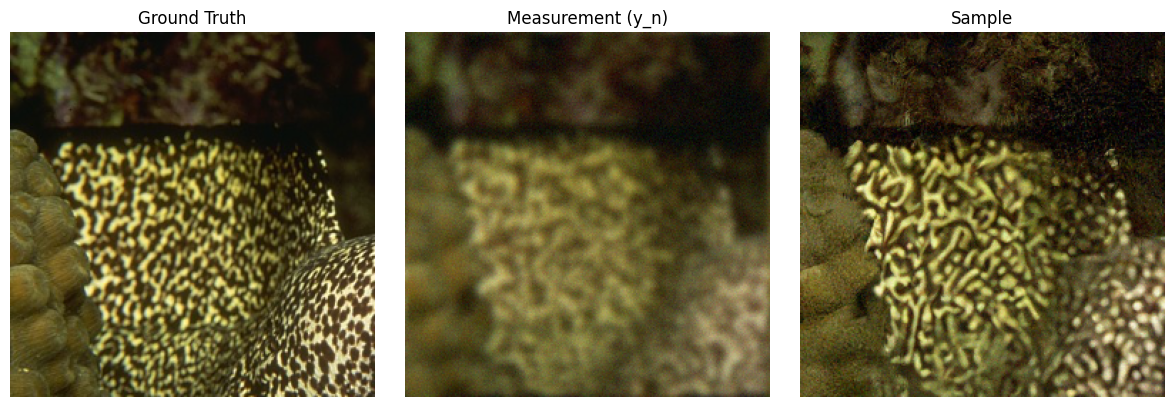

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from hydra import compose, initialize
from omegaconf import OmegaConf

if not hydra.core.global_hydra.GlobalHydra.instance().is_initialized():
    initialize(config_path="configs", job_name="debug_sample")

cfg = compose(config_name="default", overrides=[
"+data=ffhq",
"+task=gaussian_deblur_circ",
"+model=edm_unet_adm_dps_ffhq",
"+sampler=pnp_edm",
"sampler.mode=vp_sde",
"sampler.rho=10",
"sampler.rho_decay_rate=0.9",
"sampler.rho_min=0.3",
"gpu=0",
"add_exp_name=anneal-0.9"
])

print(OmegaConf.to_yaml(cfg))
posterior_sample(cfg)

### PnPEDM: Code Explanation and Its Mathematical Backbone

The `PnPEDM` class implements the **PnP-DM algorithm** introduced in the paper, combining a data-consistency step (likelihood) and a diffusion-based prior step using the **EDM framework**.

#### Key Mathematical Structure

The algorithm targets the following joint distribution:

$$
\pi(x, z) \propto \exp\left( -f(z; y) - g(x) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

We alternate between:
- **Likelihood step**: sample $z \sim \pi(z|x)$
- **Prior step**: sample $x \sim \pi(x|z)$

The `PnPEDM` class performs this alternating procedure over multiple iterations.

---

#### 1. **Initialization**

```python
x = self.operator.initialize(gt, y_n)
```

This initializes $x^{(0)}$, usually using a naive pseudoinverse or other simple method based on $y_n$.

---

#### 2. **Likelihood Step: Data Consistency**

```python
z = self.operator.proximal_generator(x, y_n, self.noiser.sigma, rho_iter)
```

This approximates sampling from:

$$
\pi(z|x) \propto \exp\left( -f(z; y) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

If the forward model is linear with Gaussian noise, this corresponds to sampling from a known Gaussian. If not, this operator may internally use gradient-based methods (e.g. Langevin).

This step ensures $z$ is consistent with measurement $y$.

---

#### 3. **Prior Step: Diffusion Denoising**

```python
x = self.edm(z, rho_iter)
```

This corresponds to sampling from:

$$
\pi(x|z) \propto \exp\left( -g(x) - \frac{1}{2\rho^2} \|x - z\|^2 \right)
$$

This is equivalent to a **Bayesian denoising problem**, where:
- The noisy observation is $z$
- The noise level is $\rho$
- The prior $p(x) \propto \exp(-g(x))$ is modeled by a **pretrained diffusion model**

The EDM framework provides a unified reverse-time SDE solver to sample from this distribution.

---

#### 4. **Annealing Schedule**

```python
rho_iter = self.config.rho * (self.config.rho_decay_rate**i)
rho_iter = max(rho_iter, self.config.rho_min)
```

This gradually reduces the noise level $\rho$, similar to simulated annealing. It improves convergence and helps escape local minima in ill-posed problems.

---

#### 5. **Sample Collection**

```python
if i in iters_count_as_sample:
    samples.append(x)
```

After the burn-in phase, $x$ samples are stored to approximate the posterior distribution $p(x|y)$.

---

#### 6. **Metrics and Visualization**

The method logs PSNR, SSIM, LPIPS over iterations, and visualizes:
- Denoised samples $x$
- Data-consistent samples $z$
- Ground truth $gt$

This helps track convergence and sample quality.

---

### Summary

The class `PnPEDM` is a direct implementation of the Split Gibbs Sampler:
- The **likelihood step** ensures fidelity to measurements
- The **prior step** leverages EDM to denoise using pretrained diffusion priors
- An annealing schedule ensures smooth convergence

This setup allows principled posterior sampling using diffusion models for both linear and nonlinear inverse problems.